In [1]:
!rm -rf

In [2]:
%pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image
import random
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics 8.3.53 🚀 Python-3.8.19 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 3090, 24245MiB)
Setup complete ✅ (24 CPUs, 62.7 GB RAM, 142.8/150.9 GB disk)


In [4]:
img_path   = 'PlantVillage_for_object_detection/Dataset/images'
label_path = 'PlantVillage_for_object_detection/Dataset/labels'

In [5]:
ipaths=[]
tpaths=[]
types=[]
for dirname, _, filenames in os.walk(img_path):
    for filename in filenames:
        ipaths+=[os.path.join(dirname, filename)]
        types+=[filename.split('.')[-1]]


for dirname, _, filenames in os.walk(label_path):
    for filename in filenames:
        tpaths+=[os.path.join(dirname, filename)]   

ipaths=sorted(ipaths)
tpaths=sorted(tpaths)

In [6]:
paths=[]
for ip,tp in zip(ipaths,tpaths):
    paths.append([ip,tp])
random.shuffle(paths)


ipaths=[]
tpaths=[]
for p in paths[:1000]:
    ipaths.append(p[0])
    tpaths.append(p[1])

In [7]:
boxdata=[]
boxfile=[]
for i in range(len(tpaths)):
    boxdata+=[np.loadtxt(tpaths[i])]     
    boxfile+=[ipaths[i].split('/')[-1]]
print(boxdata[0])

[          3     0.49219     0.49609     0.82031     0.95312]


In [8]:
boxdata[i]

array([         35,     0.49609,     0.49609,      0.9375,     0.96094])

In [9]:
All_boxes = pd.DataFrame(columns=['Class_no', 'x_coordinate','y_coordinate','width', 'height', 'name'])

for i in range(len(boxdata)):
    if type(boxdata[i][0])==np.float64:
        add=pd.DataFrame([boxdata[i]], columns=['Class_no', 'x_coordinate','y_coordinate','width', 'height'])
        add['name']=boxfile[i]
        All_boxes=pd.concat([All_boxes,add])
    else:
        add=pd.DataFrame(boxdata[i], columns=['Class_no', 'x_coordinate','y_coordinate','width', 'height'])
        add['name']=boxfile[i]
        All_boxes=pd.concat([All_boxes,add])       

All_boxes = All_boxes.reset_index(drop=True)
All_boxes.iloc[:,0] = All_boxes.iloc[:,0].astype(int)
display(All_boxes)

,Class_no,x_coordinate,y_coordinate,width,height,name
0,3.0,0.492188,0.496094,0.820312,0.953125,APHE_image (768).jpg
1,30.0,0.488281,0.441406,0.710938,0.875000,TMLB_image (618).jpg
2,17.0,0.392578,0.500000,0.691406,1.000000,PCHE_image (34).jpg
3,28.0,0.478516,0.507812,0.699219,0.984375,TMBS_image (1946).jpg
4,15.0,0.498047,0.501953,0.847656,0.964844,ORHL_image (3443).jpg
...,...,...,...,...,...,...
998,24.0,0.541016,0.564453,0.714844,0.824219,SOHE_image (1351).jpg
999,32.0,0.515625,0.490234,0.898438,0.964844,TMSL_image (65).jpg
1000,35.0,0.500000,0.505859,0.640625,0.964844,TMYC_image (897).jpg
1001,13.0,0.484375,0.476562,0.882812,0.828125,GRLB_image (269).jpg


In [10]:
def draw_box(n0):
    
    ipath=ipaths[n0]
    image=cv2.imread(ipath)
    H,W=image.shape[0],image.shape[1]
    file=ipath.split('/')[-1] 
    
    if All_boxes[All_boxes['name']==file] is not None:
        box=All_boxes[All_boxes['name']==file]
        box=box.reset_index(drop=True)
        
        for i in range(len(box)):
            label, x, y, w, h = int(box.iloc[i,0]), box.iloc[i,1], box.iloc[i,2], box.iloc[i,3], box.iloc[i,4]
            x1, y1, x2, y2=((x-w/2)*W).astype(int), ((y-h/2)*H).astype(int), ((x+w/2)*W).astype(int), ((y+h/2)*H).astype(int)
            
            cv2.rectangle(image,(x1,y1),(x2,y2),(0,0,255),2) #green
            cv2.putText(image, f'{label}', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)   

    plt.imshow(image)
    plt.show()
    
    return image

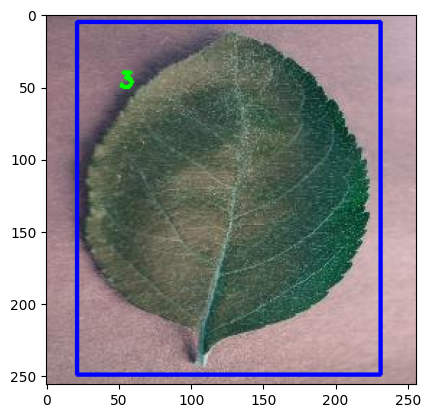

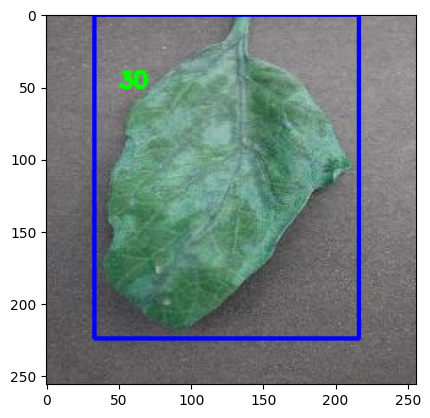

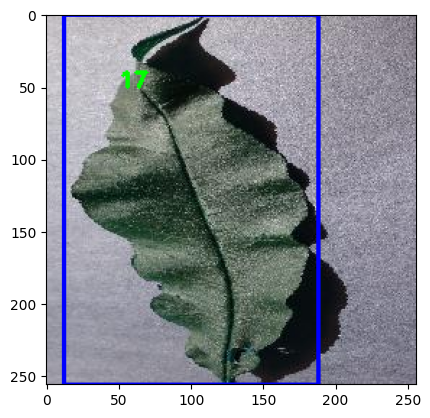

In [11]:
for i in range(3):
    draw_box(i)

In [12]:
def create_animation(ims):    
    fig=plt.figure(figsize=(10,6))
    im=plt.imshow(cv2.cvtColor(ims[0],cv2.COLOR_BGR2RGB))
    plt.show()    

In [13]:
os.makedirs('datasets', exist_ok=True)
os.makedirs('datasets/train', exist_ok=True)
os.makedirs('datasets/valid', exist_ok=True)
os.makedirs('datasets/test', exist_ok=True)

for i in range(len(ipaths)):
    ipath=ipaths[i]
    ifile=ipath.split('/')[-1]
    tpath=tpaths[i]
    tfile=tpath.split('/')[-1]

    if i%3==0:
        copyfile(ipath, f'datasets/train/{ifile}')
        copyfile(tpath, f'datasets/train/{tfile}')
    elif i%3==1:
        copyfile(ipath, f'datasets/valid/{ifile}')
        copyfile(tpath, f'datasets/valid/{tfile}')
    else:
        copyfile(ipath, f'datasets/test/{ifile}')
        #copyfile(tpath, f'datasets/test/{tfile}')  

In [14]:
import yaml

face_yaml = dict(
    train ='/media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/train',
    val ='/media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/valid',
    test='/media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/test',
    nc = 38,
    names = list(range(38))
)

with open('train_details.yaml', 'w') as outfile:
    yaml.dump(face_yaml, outfile, default_flow_style=True)
    
%cat face.yaml

cat: face.yaml: No such file or directory


In [15]:
model = YOLO("yolov8n.pt") 

# Train the model
model.train(
    data="train_details.yaml",   # path to dataset YAML
    epochs=100,
    imgsz=640,
    task="detect",    
    batch = 32 
)

New https://pypi.org/project/ultralytics/8.3.105 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.53 🚀 Python-3.8.19 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 3090, 24245MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=train_details.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

train: Scanning /media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/train... 996 images, 0 backgrounds, 0 corrupt: 100%|██████████| 996/996 [00:00<00:00, 1806.84it/s]

train: New cache created: /media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/train.cache



val: Scanning /media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/valid... 992 images, 0 backgrounds, 0 corrupt: 100%|██████████| 992/992 [00:00<00:00, 3363.87it/s]


val: New cache created: /media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/valid.cache
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000238, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.07G     0.7906      4.307      1.429         13        640: 100%|██████████| 32/32 [00:05<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]

                   all        992        992          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.68G     0.4762      3.838      1.195         15        640: 100%|██████████| 32/32 [00:04<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.67it/s]

                   all        992        992     0.0199      0.332     0.0792     0.0664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.68G     0.4561      3.254      1.178          8        640: 100%|██████████| 32/32 [00:03<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.56it/s]

                   all        992        992      0.691      0.103      0.182      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.68G     0.4477      2.766      1.146          9        640: 100%|██████████| 32/32 [00:03<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.65it/s]

                   all        992        992      0.664      0.246      0.257      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.69G     0.4626      2.417       1.15         10        640: 100%|██████████| 32/32 [00:04<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.75it/s]

                   all        992        992      0.572      0.356      0.313      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.69G     0.4483      2.127      1.133         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.89it/s]

                   all        992        992      0.576      0.435      0.405      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.69G     0.4297      1.932      1.116         12        640: 100%|██████████| 32/32 [00:03<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.87it/s]

                   all        992        992      0.555      0.472      0.491      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.69G     0.4317      1.814      1.119         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.91it/s]

                   all        992        992      0.603      0.487      0.518      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.68G     0.4164      1.681      1.112          9        640: 100%|██████████| 32/32 [00:03<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.85it/s]

                   all        992        992      0.683      0.511      0.541       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.69G     0.4129      1.586      1.105         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.80it/s]

                   all        992        992      0.692      0.591      0.628      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.69G     0.3888      1.462      1.086         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.90it/s]

                   all        992        992      0.608      0.622      0.642      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.69G     0.3804      1.371      1.081         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.71it/s]

                   all        992        992      0.642      0.652      0.679      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.69G     0.3865      1.338      1.089         12        640: 100%|██████████| 32/32 [00:03<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.99it/s]

                   all        992        992      0.831      0.567      0.706      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.68G       0.39      1.311      1.095          6        640: 100%|██████████| 32/32 [00:03<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.83it/s]

                   all        992        992      0.678       0.64      0.696      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.69G     0.3749      1.251       1.08         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.88it/s]

                   all        992        992      0.775      0.634      0.727      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.68G     0.3778      1.187      1.082          8        640: 100%|██████████| 32/32 [00:03<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.81it/s]

                   all        992        992      0.629      0.676      0.713      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.68G     0.3657      1.125      1.069          9        640: 100%|██████████| 32/32 [00:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.87it/s]

                   all        992        992      0.733      0.637      0.755      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.68G     0.3715      1.108      1.071          7        640: 100%|██████████| 32/32 [00:03<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.91it/s]

                   all        992        992      0.719      0.679      0.759      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.68G     0.3613      1.051      1.065         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.85it/s]

                   all        992        992       0.71      0.695       0.78      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.68G     0.3714      1.054      1.067         10        640: 100%|██████████| 32/32 [00:03<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.89it/s]

                   all        992        992      0.714      0.761      0.834      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.69G     0.3431     0.9768      1.057         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.87it/s]

                   all        992        992      0.722      0.783       0.84      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.69G     0.3615      1.003       1.07          8        640: 100%|██████████| 32/32 [00:03<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.89it/s]

                   all        992        992      0.779      0.733      0.836      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.69G     0.3543     0.9797      1.061         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.81it/s]

                   all        992        992        0.8      0.748      0.858      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.68G     0.3432     0.9179      1.054         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.87it/s]

                   all        992        992      0.732      0.816      0.851        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.68G     0.3398      0.916      1.055         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.92it/s]

                   all        992        992      0.824      0.788      0.888      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.68G     0.3565      0.898      1.069          9        640: 100%|██████████| 32/32 [00:03<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.90it/s]

                   all        992        992      0.821      0.799      0.882      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.68G     0.3489     0.8885      1.062          9        640: 100%|██████████| 32/32 [00:03<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.84it/s]

                   all        992        992      0.749      0.839      0.874      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.68G     0.3418     0.8525      1.051         12        640: 100%|██████████| 32/32 [00:04<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.02it/s]

                   all        992        992      0.769       0.79      0.869      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.68G      0.326     0.8262       1.04         16        640: 100%|██████████| 32/32 [00:03<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.02it/s]

                   all        992        992      0.803      0.795      0.883      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.68G     0.3433     0.8254      1.052         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.93it/s]

                   all        992        992       0.81      0.868      0.906      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.68G     0.3289     0.8134      1.042         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.93it/s]

                   all        992        992       0.84      0.846      0.911      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.68G     0.3293     0.8011      1.046          8        640: 100%|██████████| 32/32 [00:03<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.88it/s]

                   all        992        992      0.842      0.853      0.909      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.68G     0.3295      0.758      1.045         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.78it/s]

                   all        992        992      0.847      0.852      0.912      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.68G     0.3379      0.774      1.038          8        640: 100%|██████████| 32/32 [00:03<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.84it/s]

                   all        992        992       0.83      0.813      0.893       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.68G     0.3345     0.7714      1.049         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.88it/s]

                   all        992        992      0.857      0.822      0.911       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.68G     0.3358     0.7495      1.051          8        640: 100%|██████████| 32/32 [00:03<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.88it/s]

                   all        992        992      0.887      0.863      0.937      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.68G     0.3269     0.7532      1.048          8        640: 100%|██████████| 32/32 [00:03<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.97it/s]

                   all        992        992      0.851      0.827       0.91      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.68G     0.3317     0.7606      1.043         10        640: 100%|██████████| 32/32 [00:03<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.91it/s]

                   all        992        992      0.818      0.883      0.924       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.68G     0.3327     0.7454      1.053         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.87it/s]

                   all        992        992      0.836       0.87      0.914      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.68G     0.3256     0.7059      1.037         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.92it/s]

                   all        992        992      0.864      0.869      0.922      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.68G     0.3168     0.7404      1.045          6        640: 100%|██████████| 32/32 [00:03<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.82it/s]

                   all        992        992      0.884      0.868      0.937      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.68G     0.3209     0.7091       1.04          8        640: 100%|██████████| 32/32 [00:03<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.89it/s]

                   all        992        992      0.853      0.887      0.935      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.68G      0.318     0.6947      1.032         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.93it/s]

                   all        992        992      0.855      0.882      0.926      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.68G     0.3183     0.6737      1.031         16        640: 100%|██████████| 32/32 [00:03<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.86it/s]

                   all        992        992      0.878      0.809      0.909      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.68G     0.3052     0.6706      1.025         10        640: 100%|██████████| 32/32 [00:03<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.92it/s]

                   all        992        992      0.844      0.916       0.94      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.68G      0.326      0.681       1.04         12        640: 100%|██████████| 32/32 [00:03<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.99it/s]

                   all        992        992      0.815      0.872      0.923      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.68G     0.3114     0.6533      1.026         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.88it/s]

                   all        992        992       0.87      0.849      0.922      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.68G     0.3121     0.6387      1.025         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.98it/s]

                   all        992        992      0.878      0.865      0.933      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.68G     0.3116     0.6363      1.028         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.95it/s]

                   all        992        992       0.84      0.879       0.93      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.68G     0.3042     0.6302      1.025         10        640: 100%|██████████| 32/32 [00:03<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.89it/s]

                   all        992        992      0.896      0.868      0.939      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.68G     0.3041     0.6203      1.024         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.95it/s]

                   all        992        992      0.856      0.887      0.937      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.68G     0.3067     0.6135      1.025         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.70it/s]

                   all        992        992      0.874      0.899      0.934      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.68G     0.3118     0.6014      1.032         12        640: 100%|██████████| 32/32 [00:03<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.91it/s]

                   all        992        992      0.884      0.904      0.953      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.68G     0.3042     0.5862      1.024         10        640: 100%|██████████| 32/32 [00:03<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.74it/s]

                   all        992        992      0.886      0.902      0.948      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.68G     0.2945     0.5745      1.019         10        640: 100%|██████████| 32/32 [00:03<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.95it/s]

                   all        992        992       0.89       0.88      0.938      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.68G      0.318     0.6127      1.037         10        640: 100%|██████████| 32/32 [00:04<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.79it/s]

                   all        992        992      0.909      0.905      0.947      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.68G     0.2991     0.5771      1.024         12        640: 100%|██████████| 32/32 [00:03<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.79it/s]

                   all        992        992      0.893      0.905       0.95       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.68G     0.2901     0.5704      1.019         10        640: 100%|██████████| 32/32 [00:03<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.98it/s]

                   all        992        992       0.89      0.884      0.945      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.68G     0.2949     0.5808      1.022         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.02it/s]

                   all        992        992      0.874      0.891       0.94        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.68G     0.2934     0.5622       1.02         12        640: 100%|██████████| 32/32 [00:03<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.96it/s]

                   all        992        992      0.883      0.906      0.945      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.68G     0.2885     0.5593      1.022         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.70it/s]

                   all        992        992      0.871      0.913      0.938      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.68G     0.2936     0.5686      1.021          9        640: 100%|██████████| 32/32 [00:03<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.90it/s]

                   all        992        992      0.901       0.88       0.94      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.68G     0.2769     0.5368      1.006         16        640: 100%|██████████| 32/32 [00:03<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.96it/s]

                   all        992        992      0.872      0.889      0.938      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.68G     0.2829     0.5431       1.01         16        640: 100%|██████████| 32/32 [00:03<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.90it/s]

                   all        992        992        0.9      0.889      0.946      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.68G     0.2911      0.567      1.026          7        640: 100%|██████████| 32/32 [00:03<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.00it/s]

                   all        992        992      0.877      0.899      0.945      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.68G     0.3006     0.5519      1.028         10        640: 100%|██████████| 32/32 [00:03<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.96it/s]

                   all        992        992      0.873      0.922      0.948      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.68G     0.2803     0.5321      1.014         10        640: 100%|██████████| 32/32 [00:03<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.89it/s]

                   all        992        992      0.882      0.893      0.945      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.68G     0.2876      0.532      1.007         16        640: 100%|██████████| 32/32 [00:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.85it/s]

                   all        992        992      0.899      0.906      0.949      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.68G     0.2808       0.52      1.004         12        640: 100%|██████████| 32/32 [00:03<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.80it/s]

                   all        992        992        0.9      0.908      0.952      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.68G     0.2807      0.536      1.019         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.74it/s]

                   all        992        992      0.906      0.907      0.953      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.68G     0.2682      0.523      1.011         12        640: 100%|██████████| 32/32 [00:03<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.74it/s]

                   all        992        992      0.919       0.89      0.944      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.68G     0.2762     0.5112      1.004         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.92it/s]

                   all        992        992       0.91      0.896      0.947      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.68G     0.2787     0.5074      1.004         13        640: 100%|██████████| 32/32 [00:04<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.92it/s]

                   all        992        992      0.896       0.92      0.952      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.68G     0.2761      0.491      1.007         12        640: 100%|██████████| 32/32 [00:03<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.88it/s]

                   all        992        992      0.875      0.916      0.949      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.68G     0.2929     0.5164      1.016         12        640: 100%|██████████| 32/32 [00:03<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.90it/s]

                   all        992        992       0.89      0.912      0.947      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.68G     0.2759     0.5085      1.013         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.92it/s]

                   all        992        992      0.913      0.912      0.954      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.68G     0.2639     0.4948     0.9999         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.92it/s]

                   all        992        992      0.901      0.885      0.948      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.68G     0.2719     0.4888      1.005         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.86it/s]

                   all        992        992      0.901      0.917      0.953       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.68G     0.2806     0.4768      1.008         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.88it/s]

                   all        992        992      0.912        0.9      0.955      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.68G     0.2763     0.4776      1.007         12        640: 100%|██████████| 32/32 [00:03<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.77it/s]

                   all        992        992      0.904       0.91      0.954      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.68G     0.2655     0.4874          1         10        640: 100%|██████████| 32/32 [00:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.75it/s]

                   all        992        992      0.908      0.904      0.955      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.68G     0.2681     0.4745      1.008         10        640: 100%|██████████| 32/32 [00:03<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.89it/s]

                   all        992        992        0.9       0.93      0.956      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.68G     0.2744     0.4698      1.011          9        640: 100%|██████████| 32/32 [00:03<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.93it/s]

                   all        992        992      0.904      0.915      0.956      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.68G     0.2817     0.4772      1.007         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.96it/s]

                   all        992        992      0.893      0.925      0.955      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.68G     0.2755      0.475      1.001         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.93it/s]

                   all        992        992      0.907       0.91      0.955      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.68G     0.2752     0.4893      1.008         10        640: 100%|██████████| 32/32 [00:03<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.84it/s]

                   all        992        992      0.918      0.903      0.952      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.68G     0.2598     0.4547     0.9991         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.88it/s]

                   all        992        992       0.91      0.904      0.956      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.68G     0.2645     0.4673      1.002         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.91it/s]

                   all        992        992      0.897      0.929      0.962      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.68G     0.2768     0.4807      1.007         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.92it/s]

                   all        992        992      0.903      0.924       0.96      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.68G     0.2614     0.4679     0.9987         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.97it/s]

                   all        992        992      0.931      0.918      0.962       0.93


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.03G     0.1629     0.5752      0.963          4        640: 100%|██████████| 32/32 [00:04<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.95it/s]

                   all        992        992      0.899      0.933      0.956      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.68G     0.1432     0.5081     0.9348          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.92it/s]

                   all        992        992      0.889      0.928      0.952       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.68G     0.1356     0.4763     0.9448          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.95it/s]

                   all        992        992      0.913      0.913      0.951      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.68G     0.1334     0.4826     0.9454          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.90it/s]

                   all        992        992      0.884      0.928      0.951      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.68G     0.1276     0.4522     0.9377          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.98it/s]

                   all        992        992      0.909      0.921      0.954      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.68G     0.1264      0.483     0.9346          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.84it/s]

                   all        992        992      0.919      0.901      0.952      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.68G     0.1205     0.4373     0.9388          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.87it/s]

                   all        992        992       0.92      0.912      0.955      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.68G     0.1205     0.4338     0.9275          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.79it/s]

                   all        992        992      0.927      0.914      0.953      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.68G     0.1208     0.4305     0.9257          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.73it/s]

                   all        992        992      0.916      0.919      0.953      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.68G     0.1534     0.5063     0.9692          4        640: 100%|██████████| 32/32 [00:04<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.81it/s]

                   all        992        992      0.911      0.922      0.954      0.924



100 epochs completed in 0.201 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.3MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.8.19 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 3090, 24245MiB)
Model summary (fused): 168 layers, 3,013,058 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.98it/s]


                   all        992        992      0.931      0.918      0.962       0.93
                     0         12         12      0.842      0.917      0.906      0.866
                     1         12         12          1      0.729      0.954      0.909
                     2          7          7      0.971      0.857      0.978      0.947
                     3         35         35      0.943      0.943      0.973      0.916
                     4         18         18      0.974          1      0.995      0.988
                     5         19         19       0.97      0.947       0.95      0.917
                     6         17         17          1      0.924      0.984      0.949
                     7          6          6      0.831      0.821      0.838      0.735
                     8         25         25          1      0.998      0.995      0.964
                     9         22         22      0.895      0.909      0.935      0.872
                    1

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x77ba3e1c2b20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,  

In [16]:
import os
result_path = []
for dirname, _, filenames in os.walk('runs/detect/train3'):
    for filename in filenames:
        if filename[-4:]=='.png' or filename[-4:]=='.jpg':
            result_path+=[(os.path.join(dirname, filename))]
result_path=sorted(result_path)
print(result_path[0])

runs/detect/train3/F1_curve.png


In [17]:
# result_path

In [18]:
# for path in tpaths2:
#     image = Image.open(path)
#     image=np.array(image)
#     plt.figure(figsize=(20,10))
#     plt.imshow(image)
#     plt.show()

In [19]:
best_path0='runs/detect/train3/weights/best.pt'
source0='datasets/test'

In [20]:
ppaths=[]
for dirname, _, filenames in os.walk(source0):
    for filename in filenames:
        ppaths+=[(os.path.join(dirname, filename))]
ppaths=sorted(ppaths)
print(ppaths[0])
print(len(ppaths))

datasets/test/APAS_image (25).jpg
993


In [21]:
model2 = YOLO(best_path0)

results = model.predict(
    source = source0,
    conf = 0.02,
    save=True,
    save_txt = False
)


image 1/993 /media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/test/APAS_image (25).jpg: 640x640 1 0, 4.8ms
image 2/993 /media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/test/APAS_image (269).jpg: 640x640 1 0, 5.4ms
image 3/993 /media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/test/APAS_image (3).jpg: 640x640 1 0, 5.3ms
image 4/993 /media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/test/APAS_image (366).jpg: 640x640 1 0, 5.2ms
image 5/993 /media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/test/APAS_image (367).jpg: 640x640 1 0, 5.3ms
image 6/993 /media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/test/APAS_image (445).jpg: 640x640 1 0, 5.3ms
image 7/993 /media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/test/APAS_image (507).jpg: 640x640 1 0, 5.1ms
image 8/993 /media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/test/APAS_image (53).jpg: 640x640 1 0, 5.2ms
image 9/993 /media/thor/hdd

In [22]:
# results = model2.predict(source0,conf=0.02)
print(len(results))

993


In [23]:
PBOX=pd.DataFrame(columns=range(6))
for i in range(len(results)):
    arri = pd.DataFrame(results[i].boxes.data.cpu()).astype(float)
    #arri = pd.DataFrame(results[i].boxes.data).astype(float)
    path=ppaths[i]
    file=path.split('/')[-1]
    arri=arri.assign(file=file)
    arri=arri.assign(i=i)
    PBOX=pd.concat([PBOX,arri],axis=0)
PBOX.columns=['x1','y1','x2','y2','confidence','class','file','i']
PBOX['class']=PBOX['class'].astype(int)
display(PBOX)

,x1,y1,x2,y2,confidence,class,file,i
0,35.949024,0.165259,251.743805,256.000000,0.926738,0,APAS_image (25).jpg,0.0
0,0.404980,0.865503,206.769531,256.000000,0.928396,0,APAS_image (269).jpg,1.0
0,9.976465,1.264575,242.583664,256.000000,0.985293,0,APAS_image (3).jpg,2.0
0,53.018471,4.601807,201.727264,256.000000,0.910792,0,APAS_image (366).jpg,3.0
0,38.379658,15.350586,212.114822,256.000000,0.541795,0,APAS_image (367).jpg,4.0
...,...,...,...,...,...,...,...,...
1,0.000000,4.017822,11.054457,253.488678,0.021374,35,TMYC_image (895).jpg,988.0
0,25.912891,8.974097,241.138046,246.201859,0.968795,35,TMYC_image (958).jpg,989.0
0,16.311285,12.154981,216.811234,254.928009,0.949110,35,TMYC_image (971).jpg,990.0
0,40.665913,18.770826,207.005325,252.708527,0.981780,35,TMYC_image (972).jpg,991.0


In [24]:
df=PBOX.reset_index(drop=True)
display(df)
idx = df.groupby('i')['confidence'].idxmax()
df2 = df.loc[idx]
PBOX = df2.reset_index(drop=True)

,x1,y1,x2,y2,confidence,class,file,i
0,35.949024,0.165259,251.743805,256.000000,0.926738,0,APAS_image (25).jpg,0.0
1,0.404980,0.865503,206.769531,256.000000,0.928396,0,APAS_image (269).jpg,1.0
2,9.976465,1.264575,242.583664,256.000000,0.985293,0,APAS_image (3).jpg,2.0
3,53.018471,4.601807,201.727264,256.000000,0.910792,0,APAS_image (366).jpg,3.0
4,38.379658,15.350586,212.114822,256.000000,0.541795,0,APAS_image (367).jpg,4.0
...,...,...,...,...,...,...,...,...
1068,0.000000,4.017822,11.054457,253.488678,0.021374,35,TMYC_image (895).jpg,988.0
1069,25.912891,8.974097,241.138046,246.201859,0.968795,35,TMYC_image (958).jpg,989.0
1070,16.311285,12.154981,216.811234,254.928009,0.949110,35,TMYC_image (971).jpg,990.0
1071,40.665913,18.770826,207.005325,252.708527,0.981780,35,TMYC_image (972).jpg,991.0


In [25]:
def draw_box2(n0):
    
    ipath=ppaths[n0]
    image=cv2.imread(ipath)
    H,W=image.shape[0],image.shape[1]
    file=ipath.split('/')[-1]
    
    if PBOX[PBOX['file']==file] is not None:
        box=PBOX[PBOX['file']==file]
        box=box.reset_index(drop=True)
        #display(box)

        for i in range(len(box)):
            label=int(box.loc[i,'class'])
            x1=int(box.loc[i,'x1'])
            y1=int(box.loc[i,'y1'])
            x2=int(box.loc[i,'x2']) 
            y2=int(box.loc[i,'y2'])
            #print(label,x,y,x2,y2)
            cv2.rectangle(image,(x1,y1),(x2,y2),(0,255,0),2) #green

            cv2.putText(image, f'{label}', (50,50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)       
    plt.imshow(image)
    plt.show()   
    
    return image

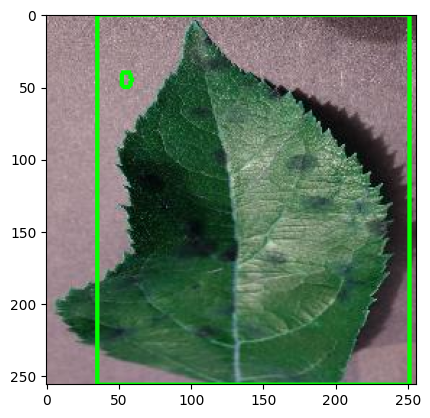

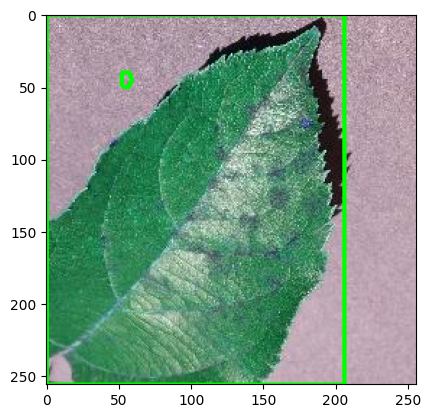

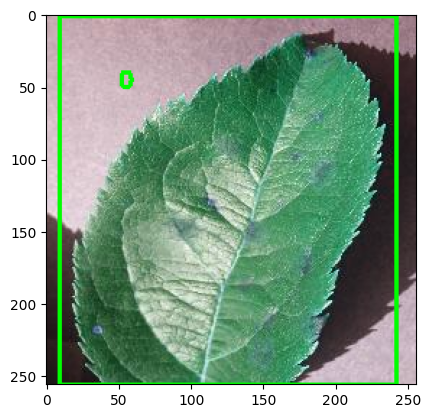

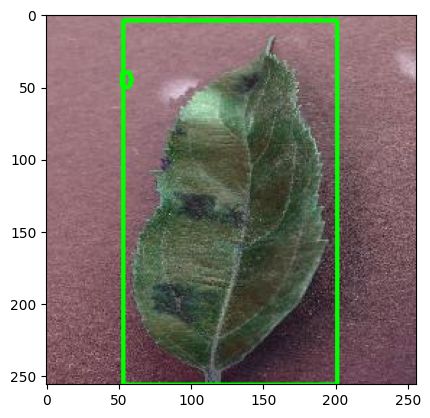

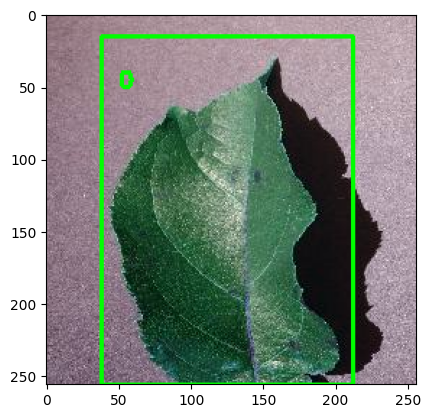

In [26]:
for i in range(5):
    draw_box2(i)